In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

%matplotlib inline

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn

import string
import re
import tqdm
from sklearn.utils import shuffle

import time

from spacy.lang.en import English
from gensim.models import Word2Vec, FastText


In [2]:
# first we will load the data
data = json.load(open('data.json'))

# now we extract sentences with events in them 
# (we are implicitly assuming here that we can exctract events without looking at sentences before or after the one 
# with the event in it)
text = [] 
lines = []
anchor_types = [] 
anchor_text = [] 

for document in data:
    for event in document['events']:
        for mention in event['MENTIONS']:
            lines.append(mention['scope_text'].replace('\n', ' '))
            anchor_types.append(event['TYPE'])
            anchor_text.append(mention['anchor_text'].replace('\n', ' '))
            
    text.append(re.sub(r'<.{1,10}>', '', document['text'].replace('\n', ' ')))

In [3]:
print(lines[:3])
print()
print(anchor_text[:3])
print()
print(anchor_types[:3])

['Even as the secretary of homeland security was putting his people on high alert last month, a 30-foot Cuban patrol boat with four heavily armed men landed on American shores, utterly undetected by the Coast Guard Secretary Ridge now leads', "And these bozos let four armed Cubans land on our shores when they're trying to make a high terrorist alert", 'He lost an election to a dead man']

['landed', 'land', 'election']

['Movement', 'Movement', 'Personnel']


#### A lot of sentences contain more than one event (right now they are stored as a separate entities in "lines", "anchor_type" and "anchor_text"). Let's regroup our dataset accordingly:

In [4]:
data = {}

for i in range(len(lines)):
    if(data.get(lines[i]) is not None):
        data[lines[i]]['anchor_type'].append(anchor_types[i])
        data[lines[i]]['anchor_text'].append(anchor_text[i])
    else:
        data[lines[i]] = {'anchor_type':[anchor_types[i]], 'anchor_text':[anchor_text[i]]}
    
pre_dataset = []
for key, value in data.items():
    pre_dataset.append({'text':key, 'anchors_type':value['anchor_type'], 'anchors_text':value['anchor_text']})

In [5]:
print('Dataset size: {}\n'.format(len(pre_dataset)))
print(pre_dataset[0])
print()
print(pre_dataset[11])
print()
print(pre_dataset[15])

Dataset size: 4382

{'text': 'Even as the secretary of homeland security was putting his people on high alert last month, a 30-foot Cuban patrol boat with four heavily armed men landed on American shores, utterly undetected by the Coast Guard Secretary Ridge now leads', 'anchors_type': ['Movement'], 'anchors_text': ['landed']}

{'text': "We're talking about possibilities of full scale war with former Congressman Tom Andrews, Democrat of Maine", 'anchors_type': ['Conflict', 'Personnel'], 'anchors_text': ['war', 'former']}

{'text': 'Let me tell you, what trips to Walter Reed taught me was, that whoever thought up the term, the law of unintended consequences it pertains to war', 'anchors_type': ['Conflict', 'Movement'], 'anchors_text': ['war', 'trips']}


#### Now we are ready to prepocess text into something pytorch will understand:

In [6]:
np.random.seed(42)

# two tokens are special. One is used if we will find token in our dataset that we do not have
# in dictionary of pretrained GloVe vectros. Second one is used so that we can process 
# sentences in batches (we padd them so that lenght is the same)
word2vec = [np.zeros(50), np.random.randn(50)]
word2id = { '__PADDING__':0, '__UNKNOWN__':1}
id2word = ['__PADDING__', '__UNKNOWN__']
i = 2

anchor_type_to_id = {name:i for name, i in zip(np.unique(anchor_types), range(len(np.unique(anchor_types))))}
id_to_anchor_type = np.unique(anchor_types)

with open('/media/sf_win/embeddings/glove.6B.50d.txt', 'r') as file:
    for line in file:
        splitted = line.split()
        token = splitted[0]
        
        word2vec.append(np.array(splitted[1:]).astype(float))
        word2id[token] = i
        id2word.append(token)
        i = i + 1

In [7]:
parser = English()

dataset = []

for sample in pre_dataset:
    parsed = parser(sample['text'])
    
    Input = np.array([word2id[token.text] if (token.text in word2id) else word2id['__UNKNOWN__'] for token in parsed])
    anchors = np.array([anchor_type_to_id[anchor] for anchor in sample['anchors_type']])
    
    tokenized_line = np.array([token.text for token in parsed])
    
    anchors_position = np.array([np.argmax(tokenized_line == anchor) for anchor in sample['anchors_text']])
    
    dataset.append({'input':Input, 'anchors_types':anchors, 'anchors_position':anchors_position})

In [8]:
# this will add to each sentence a padding token to the beginning. This is necessary because 
# we will search for events sequentialy - one by one. And if our model points at the first token
# in sentence (the padding token), we will assume there are no more events to find
# Just for convinience we will introduce special type for this "ending event" = -1
for sample in dataset:
    sample['input'] = [np.hstack([[word2id['__PADDING__']], sample['input']])]  # additional [] because torch 
    sample['anchors_position'] = sample['anchors_position'] + 1                 # only works with bactes, even
    sample['anchors_position'] = [np.hstack([sample['anchors_position'], [0]])] # if batch_size = 1
    sample['anchors_types'] = [np.hstack([sample['anchors_types'], [-1]])]

In [9]:
dataset[0]

{'input': [array([    0,     1,    21,     2,   499,     5,  3946,   196,    17,
          2222,    28,    71,    15,   154,  3641,    78,   231,     3,
             9, 36064,     1,  3475,  2379,    19,   135,  2269,  1104,
           303,  3804,    15,     1, 10264,     3, 14307, 28657,    23,
             2,     1,     1,     1,     1,   116,  2392])],
 'anchors_types': [array([ 5, -1])],
 'anchors_position': [array([28,  0])]}

In [94]:
class Policy(nn.Module):
    def __init__(self, hidden_dim = 100, dropout=0.3, num_layers=2, batch_size=1):
        super(Policy, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        # here we will store a log probabilities of chosen actions
        self.saved_log_prob = []
        
        # len(word2vec[0]) = embedding_dim
        # this transforms [batch, sentence_length] to [batch, sentence_length, embedding_dim]
        self.embeddings = nn.Embedding(len(word2vec), len(word2vec[0]), _weight=torch.FloatTensor(word2vec))
        
        # we don't wont to train already trained embeddings. Besides, this is so much faster :)
        self.embeddings.weight.requires_grad = False
        
        # this lstm will learn to point anchor position. 
        # It transforms [batch, sentence_length, embedding_dim] to [batch, sentence_length, hidden_dim]
        self.lstm_pointer = nn.LSTM(len(word2vec[0]), 
                                    hidden_dim // 2, # because bidirectional
                                    dropout=dropout, 
                                    bidirectional=True,
                                    num_layers=num_layers,
                                    batch_first=True) # batch_size first so that we don't have to permute our tensors
        self.hidden_for_pointer = self.init_hidden()
        
        # tipicaly here we would add a linear layer on top of lstm with transformation
        # [batch, sentence_length, hidden_dim] -> [batch, sentence_length, 1]
        # But we would like our prediction to be influenced by previously predicted 
        # anchors. So insted we will pass all previous predictions into forward function, multiply
        # our hidden tensor by it (our previous predictions will be a tensor of shape 
        # [number_of_prediction, hidden_dim]) and then sum over [number_of_prediction] dimension
        # Notice that this scheme only works if we add 'zero_prediction' (so we can make first prediction). 
        # It will be a constant vector of ones (normalized) 
        
        # and this one will learn to guess types of each token as if it is an anchor
        # It transforms [batch_size, sentence_length, embedding_dim] to [batch_size, sentence_length, hidden_dim]
        self.lstm_typer = nn.LSTM(len(word2vec[0]), 
                                  hidden_dim // 2, # because bidirectional
                                  dropout=dropout, 
                                  bidirectional=True,
                                  num_layers=num_layers,
                                  batch_first=True)
        self.hidden_for_typer = self.init_hidden()
        
        # this will transform [batch, sentence_length, hidden_dim] to [batch, sentence_length, 7]
        self.linear_over_typer = nn.Linear(hidden_dim, 7)
    
        #the following is done for computational efficiency:
        self.encoded_integers_array = np.array(list(map((lambda n: self.encode_integer(n, self.hidden_dim // 2)), 
                                                        np.arange(0, 100))))
        
        
    def init_hidden(self):
        return (Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim // 2)),
                Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim // 2)))    
        
    def reinit_hidden(self):
        self.hidden_for_pointer = self.init_hidden()
        self.hidden_for_typer = self.init_hidden()
    
    def forward(self, state):
        """
            This returns tensor of [batch_size, sentence_lenght, number_of_anchor_types=7],
            where each element in batch the probability of token in *position* 
            be an *anchor_type* is [*batch*, *position*, *anchor_type*]. 
            probabilities normalized for each element in batch (so that sum(output) = batch_size)
            
            'state' is a tuple, where state[0] is an input sentence (numpy array of type int and shape 
            [batch_size, sentence_length]) and state[1] is a list of actions 
            (Each action is a pair of integer numbers (anchor_position, anchor_type))
        """
        
        Input = torch.LongTensor(state[0]).detach()
        
        embeded = self.embeddings(Input)
        
        ###############  first we predict a best position for anchor        ################
        lstm_pos_out, self.hidden_for_pointer = self.lstm_pointer(embeded, self.hidden_for_pointer)
        
        actions = torch.FloatTensor(self.encode_actions(state[1])).detach()
        
        # 'filter' may be to exagerated of a word, but that's the idea 
        # this transforms [batch_size, sentence_length, hidden_dim] first to
        # [batch_size, sentence_length, len(actions)] by multiplication and then
        # to [batch_size, sentence_length] by summation
        filter_previous_actions = (lstm_pos_out @ actions).sum(dim=2)
        
        pred_pos = nn.functional.softmax(filter_previous_actions, dim=1)
        
        ###############  next we predict a best anchor type for each token  ################
        lstm_typer_out, self.hidden_for_typer = self.lstm_typer(embeded, self.hidden_for_typer)
        
        # notice that here we apply softmax over third dimention. This way we normalized 
        # pseudo-probabilities over anchor_types and over sentence lenght (as was the case 
        # when we were predicting position of anchor)
        pred_types = nn.functional.softmax(self.linear_over_typer(lstm_typer_out), dim=2)
        
        return (pred_types.permute(0, 2, 1) * pred_pos).permute(0, 2, 1)
        
        
        
    def encode_actions(self, batched_actions):
        """
        Actions a torch 3d numpy array with shape [batch_size, length_of_history, 2]. 
        where *length_of_history* is how many actions were taken previously
        Each action is a pair of integer numbers (anchor_position, anchor_type)
        This returns a numpy float array of shape [batch_size, hidden_dim, number_of_actions = len(actions)]
        """
#         return [np.array([np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)] + [np.hstack([self.encode_integer(action[0], self.hidden_dim // 2), 
#                     self.encode_integer(action[1], self.hidden_dim // 2)]) for action in actions]).T for actions in batched_actions]

        return [np.vstack([np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)] + [np.hstack([self.encoded_integers_array[action[0]], 
                    self.encoded_integers_array[action[1]]]) for action in batched_actions[0]]).T]
        
    
    
    def encode_integer(self, n, dim):
        # this weird construction with .T.flatten() is only so that in the output array sin and cos 
        # would be one after another(sin(a/i*x), cos(a/i*x), sin(a/(i+1)*x), cos(a/(i+1)*x) and so on). 
        # It is not necessary, i just like it more. Simpler alternative is 
        # np.hstack([[np.sin((a/i)*n) for i in range(1, dim // 2 + 1)], [np.cos((a/i)*n) for i in range(1, dim // 2 + 1)]])

        a = 2. * np.pi * np.sqrt(dim)
        
        return np.vstack([[np.sin((a/i)*n) for i in range(1, dim // 2 + 1)], [np.cos((a/i)*n) for i in range(1, dim // 2 + 1)]]).T.flatten()

In [95]:
policy = Policy()
params = filter(lambda x: x.requires_grad, policy.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

In [12]:
def select_action(state):
    # this returns a selected action for every state in the batch.
    # the output is a torch.LongTensor of shape [batch_size, 2], where
    # first element is chosen anchor_position and the second - anchor_type
    
    prob = policy(state)
    
    # this creates a categorical distributions for positions for each element in batch
    distr_pos = torch.distributions.Categorical(probs=prob.sum(dim=2))

    chosen_positions = distr_pos.sample()

    # here we create a distributions of anchor_types for sampled token positions in each batch
    distr_types = torch.distributions.Categorical(probs=prob[:, chosen_positions, :].squeeze(dim=1))

    chosen_types = distr_types.sample()

    # log(a*b) = log(a) + log(b)
    policy.saved_log_prob.append(distr_pos.log_prob(chosen_positions) + distr_types.log_prob(chosen_types))
    
    return torch.cat([chosen_positions.unsqueeze(0), chosen_types.unsqueeze(0)], dim=1).unsqueeze(1)

In [29]:
# i don't yet know how to deal with batch processing when it is unknown when cicle will be terminated
# (what to do if one element in batch terminated, but others are not yet finished?)
# so for now this is the first place that will not work unless batch_size=1

alpha_pos = 1.
alpha_pos_miss = 0.5
alpha_type = 1.
alpha_additional_events = 0.2
alpha_not_enought_events = 5

# we will calculate reward in the foolwing way:
# if a chosen position is in sample['anchors_position'] we add alpha_pos
# if a chosen position is not in there, we will subtract alpha_pos_miss * np.min(np.abs(pos - real_pos))
# (which is distance to a closest anchor position)
# if a chosen anchor type is in sample['anchors_types'], we add alpha_type 

# if after a termination we found more (or less) events than in ground truth, 
# we subtract alpha_number_of_events * (real_number_of_events - i)**2 from every i-th event that was 
# predicted after real_number_of_events (except the last one) and subtracts alpha_not_enought_events * np.abs(real_number_of_events - i)
# from the premature termination step

def get_imediate_reward(action, sample):
    # remember that one action is a LongTensor with shape [batch_size, 1, 2]
    reward_ = [0] * policy.batch_size # there will be batch_size number of rewards
    
#     for i in range(policy.batch_size):
#         if(action[i, 0, 0].item() in sample['anchors_position'][i]):
#             reward_[i] += alpha_pos
#         else:
#             reward_[i] -= alpha_pos_miss * np.min(np.abs(sample['anchors_position'][i] - action[i, 0, 0].item()))

#         if(action[i, 0, 1].item() in sample['anchors_types'][i]):
#             reward_[i] += alpha_type
    
    if(action[0, 0, 0].item() in sample['anchors_position'][i]):
        reward_[0] += alpha_pos
    else:
        reward_[0] -= alpha_pos_miss * np.min(np.abs(sample['anchors_position'][i] - action[0, 0, 0].item()))

    if(action[0, 0, 1].item() in sample['anchors_types'][i]):

    
    return np.array(reward_)
           

def iterate_training_sample(sample):
    reward = []
    policy.saved_log_prob = []
    policy.reinit_hidden()

    state = (sample['input'], [[]])
    action = select_action(state)
    reward.append(get_imediate_reward(action, sample))
    stop_counter = 7 # here we cheat a bit, cause in the dataset there are samples with more events than 7
                     # but there are less then 10 of them, so it's not that big of a deal

    action_history = action

    while(action[0, 0, 0].is_nonzero() and stop_counter > 0):
        stop_counter = stop_counter - 1

        state = (sample['input'], action_history)
        action = select_action(state)

        reward.append(get_imediate_reward(action, sample))

        action_history = torch.cat([action_history, action], dim=1)

    # rigth now reward have the shape [action_history, batch_size], so we would like to 
    # reverse it for consistency
    reward = np.array(reward).T

    # don't forget - action_history is a torch tensor of shape [batch_size, history_lenght, 2]
    # and sample['anchors_position'] is a numpy array of shape [batch_size, number_of_events_in_sentence + 1]
    # where +1 is a termination "event"
    if(action_history.shape[1] > len(sample['anchors_position'][0])):
        overshots = reward[:, len(sample['anchors_position'][0]) - 1:-1] 

        overshots -= alpha_additional_events * np.array([np.arange(1, len(overshots[0]) + 1)**2 for _ in range(len(overshots))])

        reward[:, len(sample['anchors_position'][0]) - 1:-1] = overshots
    elif(action_history.shape[1] < len(sample['anchors_position'][0])):
        reward[:, -1] -= alpha_not_enought_events * (len(sample['anchors_position'][0]) - action_history.shape[1])


    reward = torch.FloatTensor(reward)
    loss = -(torch.cat(policy.saved_log_prob) * reward).sum(dim=1)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    del policy.saved_log_prob[:]
    del reward
    
    return torch.mean(loss.data).detach().item()


def predict(sample):
    state = (sample['input'], [[]])
    
    policy.reinit_hidden()
    pred = policy(state)

    positions = pred.sum(dim=2).argmax(dim=1)
    types = pred[:, positions, :].argmax(dim=2)

    action = torch.cat((positions.unsqueeze(0), types), dim=1).unsqueeze(1)
    
    action_history = action
    stop_counter = 17
    
    while(action[0, 0, 0].is_nonzero() and stop_counter > 0):
        stop_counter = stop_counter - 1

        state = (sample['input'], action_history)
        pred = policy(state)
        positions = pred.sum(dim=2).argmax(dim=1)
        types = pred[:, positions, :].argmax(dim=2)
        action = torch.cat((positions.unsqueeze(0), types), dim=1).unsqueeze(1)

        action_history = torch.cat([action_history, action], dim=1)
    
    return action_history
    

def score_prediction(action_history, sample):
    if(action_history.shape[1] > 1):
        pred_types = action_history[:, :-1, 1].numpy()
        real_types = np.array(sample['anchors_types'])[:, :-1]
    else:
        pred_types = action_history[:, :, 1].numpy()
        real_types = np.array(sample['anchors_types'])[:, :-1]
    
    recall_data_type = np.array([[event in pred_pos_ for event in real_pos_] for pred_pos_, real_pos_ in zip(pred_types, real_types)])
    accuracy_data_type = np.array([[event in real_pos_ for event in pred_pos_] for pred_pos_, real_pos_ in zip(pred_types, real_types)])

    mean_recall_type = (recall_data_type.sum(axis=1) / recall_data_type.shape[1]).mean()
    mean_accuracy_type = (accuracy_data_type.sum(axis=1) / accuracy_data_type.shape[1]).mean()

    f1_type = 2.* mean_recall_type * mean_accuracy_type / (mean_recall_type + mean_accuracy_type + 1e-7)

    if(action_history.shape[1] == 1):
        return 0., mean_accuracy_type, 0., mean_recall_type, 0., f1_type
    else:
        pred_pos = action_history[:, :-1, 0].numpy()
        real_pos = np.array(sample['anchors_position'])[:, :-1]

    recall_data_pos = np.array([[event in pred_pos_ for event in real_pos_] for pred_pos_, real_pos_ in zip(pred_pos, real_pos)])
    accuracy_data_pos = np.array([[event in real_pos_ for event in pred_pos_] for pred_pos_, real_pos_ in zip(pred_pos, real_pos)])

    mean_recall_pos = (recall_data_pos.sum(axis=1) / recall_data_pos.shape[1]).mean()
    mean_accuracy_pos = (accuracy_data_pos.sum(axis=1) / accuracy_data_pos.shape[1]).mean()

    f1_pos = 2.* mean_recall_pos * mean_accuracy_pos / (mean_recall_pos + mean_accuracy_pos + 1e-7)

    return mean_accuracy_pos, mean_accuracy_type, mean_recall_pos, mean_recall_type, f1_pos, f1_type


EPOCH = 20    

dataset_train, dataset_test = train_test_split(dataset, test_size=0.5)

reward_history = []
stats_history = []

for i in range(EPOCH):
    print('==========================================================================')
    print('Epoch {}:'.format(i))
    
    dataset_train = shuffle(dataset_train)
    
    reward_over_training_dataset = 0
    
    print('Iterating over training dataset...', end='')
    for sample in dataset_train:
        
        reward_over_training_dataset += iterate_training_sample(sample)
    
    reward_history.append(reward_over_training_dataset)
    print('finished\n Mean reward over training dataset = {}'.format(reward_over_training_dataset / len(dataset_train)))
    recall = []
    accuracy = []
    f1 = []
    
    print('\nScoring test dataset...', end='')
    
    for sample in dataset_test:
        
        predicted_actions = predict(sample)
        
        mean_accuracy_pos, mean_accuracy_type, mean_recall_pos, mean_recall_type, f1_pos, f1_type = score_prediction(predicted_actions, sample)
        
        accuracy.append((mean_accuracy_pos, mean_accuracy_type))
        recall.append((mean_recall_pos, mean_recall_type))
        f1.append((f1_pos, f1_type))
    
    recall = np.array(recall).mean(axis=0)
    accuracy = np.array(accuracy).mean(axis=0)
    f1 = np.array(f1).mean(axis=0)
    
    stats_history.append(np.hstack([accuracy, recall, f1]))
    
    print("scored")
    print('Accuracy of position = {:.2f}, accuracy of type = {:.2f}'.format(accuracy[0], accuracy[1]))
    print('Recall of position = {:.2f}, recall of type = {:.2f}'.format(recall[0], recall[1]))
    print('F1 score of position = {:.2f}, F1 of type = {:.2f}'.format(f1[0], f1[1]))
        


Epoch 0:
Iterating over training dataset...finished
 Mean reward over training dataset = -89.38122593377182

Scoring test dataset...scored
Accuracy of position = 0.10, accuracy of type = 0.35
Recall of position = 0.09, recall of type = 0.29
F1 score of position = 0.09, F1 of type = 0.31
Epoch 1:
Iterating over training dataset...finished
 Mean reward over training dataset = -6.327738060695444

Scoring test dataset...scored
Accuracy of position = 0.13, accuracy of type = 0.35
Recall of position = 0.11, recall of type = 0.29
F1 score of position = 0.11, F1 of type = 0.31
Epoch 2:
Iterating over training dataset...finished
 Mean reward over training dataset = -4.032647921997477

Scoring test dataset...scored
Accuracy of position = 0.16, accuracy of type = 0.35
Recall of position = 0.14, recall of type = 0.29
F1 score of position = 0.14, F1 of type = 0.31
Epoch 3:
Iterating over training dataset...finished
 Mean reward over training dataset = -3.8149644111247842

Scoring test dataset...sco

In [ ]:
np.array([(1, 1), (2, 5), (-1, 3)]).mean(axis=0)

In [15]:
action_history

NameError: name 'action_history' is not defined

In [26]:
predict(dataset_test[0])[:, :, 1]

tensor([[ 1]])

(array([[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]]), array([[4]]))

In [86]:
def score_prediction(pred, real):
    # [bacth_size, prediction_length, 2] and [batch_size, number_of_events, 2]
    
    

In [96]:
if((i[:, :, 0] > 0).all()):
    print(5)

In [196]:

policy.reinit_hidden()

action = select_action(state)

stop_counter = 17

action_history = action

while(action[0, 0, 0].is_nonzero() and stop_counter > 0):
    stop_counter = stop_counter - 1

    state = (sample['input'], action_history)
    action = select_action(state)

    reward.append(get_imediate_reward(action, sample))

    action_history = torch.cat([action_history, action], dim=1)

[]

In [171]:
torch.mean(a3)

RuntimeError: mean is not implemented for type torch.LongTensor

In [125]:
a = [[]]

a3 = select_action((dataset[0]['input'], torch.cat([a2, a1], dim=1)))

In [126]:
a3

tensor([[[ 40,   4]]])

In [110]:
torch.cat([torch.FloatTensor(a), a1.float()], dim=1)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 50 and 2 in dimension 2 at /opt/conda/conda-bld/pytorch-cpu_1524582300956/work/aten/src/TH/generic/THTensorMath.c:3586

In [60]:
chosen_types

In [23]:
prob = policy()

In [137]:
torch.ones((3, 4)).sum()

tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])

In [135]:
m.sample()

tensor([ 2,  1,  3])

(array([3.22e+03, 8.74e+02, 2.02e+02, 5.90e+01, 2.00e+01, 2.00e+00,
        1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 2.00e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16.]),
 <a list of 15 Patch objects>)

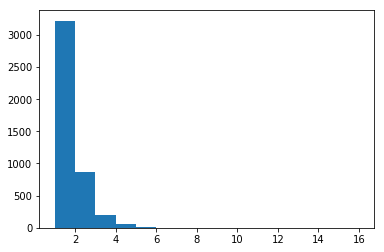

In [15]:
# let's see how many samples have more than one event:
number_of_events = [len(sample['anchors_types']) for sample in dataset]

# wow, there are even sentences with 16 events!
plt.hist(number_of_events, bins=15)

In [30]:
# for now i do not imlement batch processing, since it is unlikely to necessary for such a small dataset

# def group_dataset (dataset):
#     # we would like to pad our sentences to the same lenght (for batching), but if were to pad them to
#     # maximum length, they all will be extreamly long (~160 tokens) and it will slow down computation
#     # even with batching. So we will split them in several groups

#     lenghts = [len(sample['input']) for sample in dataset]
    
#     # the borders are picked more-or-less empiricaly so that the group sizes are aproximately equal
#     group1 = np.array(lenghts) < 16
#     group2 = np.logical_and(np.array(lenghts) >= 16, np.array(lenghts) < 23)
#     group3 = np.logical_and(np.array(lenghts) >= 23, np.array(lenghts) < 32)
#     group4 = np.array(lenghts) >= 32
#     groups = [group1, group2, group3, group4]
    
#     new_dataset = []
    
#     for group in groups:
#         new_dataset.append(np.array(dataset)[group])
    
#     return new_dataset

# def iterate_batches (dataset):
#     pass
    

In [25]:
class EventPointerNetwork(nn.Module):
    def __init__(self, 
                 data_file_name = 'data.json', 
                 embedding_dim=100, 
                 hidden_dim = 100, 
                 batch_size=1, 
                 lstm_layers=1,
                 mode='train_word2vec',
                 trainable_embedding = False,
                 use_unknown_token=False,
                 added_noise_varience=0.1):
        
        super(EventPointerNetwork, self).__init__()
        
        self.data_file_name = data_file_name
        self.lstm_layers = lstm_layers
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        self.rotation = Variable(torch.FloatTensor(ortho_group.rvs(dim=100, size=self.batch_size)), requires_grad=False)
        self.added_noise_varience = added_noise_varience
        
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=hidden_dim // 2,  # because bidirectional
                            num_layers=lstm_layers,
                            bidirectional=True)
        
        self.hidden = self.init_hidden(batch_size=batch_size)
        
        # this layer will transform [sequence_lenght, hidden_dim] to [sequence_lenght, 1] so that we can apply softmax
        # and get a word in sequance which is the most likely "action anchor"
        self.linear = nn.Linear(hidden_dim, 1)
        
        self.LoadAndTokenizeData(mode='spacy')
        self.InitEmbeddingAndCreateDataset(mode=mode, trainable = trainable_embedding, use_unknown_token=use_unknown_token)
    
    def LoadAndTokenizeData(self, mode='spacy'):
        """This function will load the data fron json file self.data_file_name. Then it will tokenize it
           using either spacy parser or simple splitting. Tokenized data will be saved in self.tokenized_lines
           
           INPUT:
               mode - string. Either 'spacy' or 'simple_split'
        """
        # first we will load the data
        data = json.load(open(self.data_file_name))
        
        # now we extract sentences with events in them 
        # (we are implicitly assuming here that we can exctract events without looking at sentences before or after the one 
        # with the event in it)
        lines = []
        anchor_types = [] 
        self.anchor_text = [] # both lines and anchor_types we do not need outside this function, but anchor_text we will need
                              # to save untill creation of token vocabulary

        for text in data:
            for event in text['events']:
                for mention in event['MENTIONS']:
                    lines.append(mention['scope_text'])
                    anchor_types.append(event['TYPE'])
                    self.anchor_text.append(mention['anchor_text'])
    
        # parse and tokenize. TODO: create vocab out of all text, not only with events
        if(mode == 'spacy'): # using sapcy english parser with fancy rules
            parser = English()
            self.tokenized_lines = [[token.text for token in parser(line.replace('\n', ' '))] for line in lines]
            del parser 
        elif(mode == 'simple_split'):  # or just splitting sentences as is
            self.tokenized_lines = [line.replace('\n', ' ').split() for line in lines]
    
        # assign each event name a unique number
        anchor_type_to_id = {name:i for name, i in zip(np.unique(anchor_types), range(len(np.unique(anchor_types))))}
        self.anchor_labels = [anchor_type_to_id[anchor_type] for anchor_type in anchor_types]
        
    
    def InitEmbeddingAndCreateDataset(self, 
                                      mode='train_word2vec',
                                      trainable = False,
                                      use_unknown_token=False, 
                                      min_count=3, window=5, test_ratio=0.2):
        
        if(mode == 'random'):
            pass # will do later
        elif(mode == 'train_word2vec'):
            if(use_unknown_token):
                self.tokenized_lines.append(['_UNKNOWN_'] * min_count)
            model = Word2Vec(sentences=self.tokenized_lines, 
                             size=self.embedding_dim, 
                             window=5, 
                             min_count=min_count, 
                             workers=2, sg=0)
            
            filtered_tokenized_lines = []
            
            if(use_unknown_token):
                for line in self.tokenized_lines:
                    filtered_tokenized_lines.append([token if token in model.wv.vocab else '_UNKNOWN_' for token in line])
            else:
                for line in self.tokenized_lines:
                    filtered_tokenized_lines.append([token for token in line if(token in model.wv.vocab)])
                    
            word2id = {word:model.wv.index2word.index(word) for word in model.wv.index2word}
        
            self.embeddings = nn.Embedding(len(model.wv.vectors), self.embedding_dim)
            self.embeddings.weight.data.copy_(torch.from_numpy(model.wv.vectors))
            if(not trainable):
                self.embeddings.weight.requires_grad = False
        
        dataset = []
        for i in range(len(filtered_tokenized_lines) - int(use_unknown_token)):
            
            # if anchor word does not appear in dictionary, we skipp this sample (otherwise 
            # we will be trying to point to a word we can't see, which is pointles)
            if(self.anchor_text[i] in filtered_tokenized_lines[i]):
                Anchor_position = filtered_tokenized_lines[i].index(self.anchor_text[i])
            else: 
                continue
            
            Input = Variable(torch.LongTensor([word2id[word] for word in filtered_tokenized_lines[i]]),
                             requires_grad=False)
            
            data_point = {'Input':Input.resize(1, len(Input)),  #no batches for now
                          'Anchor position':Variable(torch.LongTensor([Anchor_position]), requires_grad=False),
                          'Anchor label':Variable(torch.LongTensor([self.anchor_labels[i]]), requires_grad=False)}
            
            dataset.append(data_point)
        
        self.train_dataset, self.test_dataset = train_test_split(dataset, test_size=test_ratio)
            
    
    def init_hidden(self, batch_size=1):
        return (Variable(torch.zeros(self.lstm_layers * 2, batch_size, self.hidden_dim // 2)),
                Variable(torch.zeros(self.lstm_layers * 2, batch_size, self.hidden_dim // 2)))
    
    def train_(self, epochs = 20, lr=1e-3, wd=1e-4, augmentation=False):
        
        loss_function = nn.CrossEntropyLoss()
        parameters = filter(lambda x: x.requires_grad, self.parameters())
        optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
        
        train_losses = []
        
        for i in tqdm.tqdm_notebook(range(epochs)):
            
            train_losses.append([0])
            
            # switch to train mode 
            self.train()
            
            for sample in self.train_dataset:
                if(augmentation):
                    self.hidden = self.init_hidden(batch_size=self.batch_size)
                else:
                    self.hidden = self.init_hidden()
                
                pred = self.forward(sample['Input'], augmentation=augmentation)
                
                loss = loss_function(pred, sample['Anchor position'])
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_losses[-1].append(loss.data[0])
            
            # switch to evaluation mode (switch off dropout and batch norm)
            self.eval()
            
            pred_correctly = 0
            
            for sample in self.test_dataset:
                self.hidden = self.init_hidden()
                
                pred = self.forward(sample['Input'])
                
                _, collased_pred = torch.max(pred.data, 1)
                
                if(collased_pred[0] == sample['Anchor position'].data[0]):
                    pred_correctly += 1
                
            acc = float(pred_correctly) / len(self.test_dataset)
            
            print('Epoch {}. Train loss: {:.2f}. Test accuracy: {:.2f}'.format(i, np.sum(train_losses[-1]), acc))
            
    def forward(self, Input, augmentation=False):
        embeded = self.embeddings(Input)
        
        if(augmentation):
            embeded = embeded * Variable(1 + self.added_noise_varience*torch.randn((self.batch_size, 1, self.embedding_dim)),
                                        requires_grad = False)
        
        lstm_output, self.hidden = self.lstm(embeded.permute(1, 0, 2), self.hidden)
        
        return nn.functional.softmax(
            self.linear(lstm_output.resize(lstm_output.size()[0] * lstm_output.size()[1], lstm_output.size()[2])), dim=0).permute(1, 0)

In [26]:
model = EventPointerNetwork(trainable_embedding = True, use_unknown_token=False, batch_size=10)

In [4]:
import timeit

In [27]:
%timeit model.forward(model.train_dataset[0]['Input'], augmentation=True)

14.4 ms ± 547 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
model = EventPointerNetwork(trainable_embedding = False, use_unknown_token=False)
model.train_()

Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch 0. Train loss: 12762.50. Test accuracy: 0.13, recall: 0.13, precision: 0.13, F1: 0.13
Epoch 1. Train loss: 12661.60. Test accuracy: 0.13, recall: 0.13, precision: 0.13, F1: 0.13
Epoch 2. Train loss: 12636.79. Test accuracy: 0.12, recall: 0.12, precision: 0.12, F1: 0.12
Epoch 3. Train loss: 12605.39. Test accuracy: 0.13, recall: 0.13, precision: 0.13, F1: 0.13
Epoch 4. Train loss: 12563.50. Test accuracy: 0.15, recall: 0.15, precision: 0.15, F1: 0.15
Epoch 5. Train loss: 12530.89. Test accuracy: 0.16, recall: 0.16, precision: 0.16, F1: 0.16
Epoch 6. Train loss: 12472.59. Test accuracy: 0.17, recall: 0.17, precision: 0.17, F1: 0.17
Epoch 7. Train loss: 12400.89. Test accuracy: 0.24, recall: 0.24, precision: 0.24, F1: 0.24
Epoch 8. Train loss: 12313.11. Test accuracy: 0.27, recall: 0.27, precision: 0.27, F1: 0.27
Epoch 9. Train loss: 12280.85. Test accuracy: 0.26, recall: 0.26, precision: 0.26, F1: 0.26
Epoch 10. Train loss: 12245.61. Test accuracy: 0.27, recall: 0.27, precision: 0.

In [4]:
model = EventPointerNetwork(trainable_embedding = True, use_unknown_token=False)
model.train_()

Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch 0. Train loss: 11356.69. Test accuracy: 0.58, recall: 0.58, precision: 0.58, F1: 0.58
Epoch 1. Train loss: 10826.73. Test accuracy: 0.58, recall: 0.58, precision: 0.58, F1: 0.58
Epoch 2. Train loss: 10760.07. Test accuracy: 0.60, recall: 0.60, precision: 0.60, F1: 0.60
Epoch 3. Train loss: 10700.07. Test accuracy: 0.59, recall: 0.59, precision: 0.59, F1: 0.59
Epoch 4. Train loss: 10660.80. Test accuracy: 0.60, recall: 0.60, precision: 0.60, F1: 0.60
Epoch 5. Train loss: 10617.44. Test accuracy: 0.60, recall: 0.60, precision: 0.60, F1: 0.60
Epoch 6. Train loss: 10610.16. Test accuracy: 0.60, recall: 0.60, precision: 0.60, F1: 0.60
Epoch 7. Train loss: 10603.81. Test accuracy: 0.61, recall: 0.61, precision: 0.61, F1: 0.61
Epoch 8. Train loss: 10572.47. Test accuracy: 0.59, recall: 0.59, precision: 0.59, F1: 0.59
Epoch 9. Train loss: 10534.71. Test accuracy: 0.61, recall: 0.61, precision: 0.61, F1: 0.61
Epoch 10. Train loss: 10531.27. Test accuracy: 0.59, recall: 0.59, precision: 0.

In [5]:
model = EventPointerNetwork(trainable_embedding = False, use_unknown_token=True)
model.train_()

Epoch 0. Train loss: 12967.81. Test accuracy: 0.16, recall: 0.16, precision: 0.16, F1: 0.16
Epoch 1. Train loss: 12891.55. Test accuracy: 0.18, recall: 0.18, precision: 0.18, F1: 0.18
Epoch 2. Train loss: 12862.82. Test accuracy: 0.14, recall: 0.14, precision: 0.14, F1: 0.14
Epoch 3. Train loss: 12809.88. Test accuracy: 0.19, recall: 0.19, precision: 0.19, F1: 0.19


KeyboardInterrupt: 

In [29]:
model = EventPointerNetwork(trainable_embedding = True, use_unknown_token=False, batch_size=10, added_noise_varience=0.01)
model.train_(augmentation=True)

Exception in thread Thread-49:
Traceback (most recent call last):
  File "/home/student/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/student/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/student/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Epoch 0. Train loss: 22542.93. Test accuracy: 0.01
Epoch 1. Train loss: 22538.52. Test accuracy: 0.01
Epoch 2. Train loss: 22538.46. Test accuracy: 0.01
Epoch 3. Train loss: 22538.46. Test accuracy: 0.01



KeyboardInterrupt: 

In [11]:
ortho_group.rvs(dim=100, size=1)

array([[ 0.107873  , -0.14772108, -0.00431708, ...,  0.00620962,
        -0.02809927, -0.03568291],
       [-0.02488238,  0.06697029, -0.08345047, ...,  0.02791858,
        -0.00062978,  0.03429892],
       [ 0.02105349,  0.00685935,  0.12863055, ..., -0.16188012,
         0.07248722, -0.03051877],
       ...,
       [ 0.04766418,  0.14956476,  0.19661506, ..., -0.07164895,
         0.00184981,  0.17163976],
       [ 0.18516098,  0.18092651, -0.08862681, ..., -0.13351746,
        -0.04337998, -0.02686833],
       [-0.09572826,  0.00231094,  0.10542071, ..., -0.16580989,
        -0.25362044,  0.16321052]])

In [17]:
wv = model.embeddings(model.train_dataset[0]['Input']).data[0, 0, :].numpy()

In [29]:
wv @ ortho_group.rvs(dim=100, size=1, random_state=42)

array([ 0.00639549,  0.02478294, -0.03556288,  0.02758429, -0.03052169,
        0.05740496, -0.05428189, -0.04999069,  0.02229912,  0.00859046,
       -0.00764467,  0.06781983, -0.05810191, -0.01523107,  0.04677327,
       -0.03403283,  0.04241906,  0.07917542,  0.02908635, -0.02563982,
        0.02447637, -0.00227952,  0.08291341,  0.01861861, -0.01903705,
       -0.00591173, -0.01842427,  0.01474347,  0.04095296,  0.00216009,
       -0.0174778 , -0.01352988,  0.07130295,  0.00138191,  0.01719273,
       -0.01081256, -0.00988321,  0.00543546,  0.06191076, -0.0011535 ,
       -0.03407233,  0.01007321, -0.00492583,  0.02421363, -0.01700173,
       -0.02944059,  0.01196152, -0.02628855,  0.03551354, -0.07877893,
       -0.04407536,  0.01080482,  0.01933007,  0.00683997,  0.01266157,
        0.05913918, -0.0517735 ,  0.02160677,  0.01413801,  0.06702278,
        0.03176447,  0.02949127, -0.0087865 ,  0.02734794,  0.03339221,
       -0.03924424,  0.05853817, -0.01468915,  0.00685779,  0.01

Variable containing:
( 0 ,.,.) = 
  0.0064  0.0248 -0.0356  ...  -0.0891 -0.0156  0.0028
  0.0002  0.0176 -0.0338  ...  -0.0679 -0.0139 -0.0027
  0.0815  0.4256 -0.5050  ...  -1.1638 -0.0886 -0.1622
           ...             ⋱             ...          
  0.0305  0.0780 -0.1618  ...  -0.3365 -0.0756 -0.0189
  0.1230  0.2651 -0.5535  ...  -1.1788 -0.2414 -0.0128
  0.0095  0.0148 -0.0301  ...  -0.0672 -0.0188 -0.0024

( 1 ,.,.) = 
  0.0064  0.0248 -0.0356  ...  -0.0891 -0.0156  0.0028
  0.0002  0.0176 -0.0338  ...  -0.0679 -0.0139 -0.0027
  0.0815  0.4256 -0.5050  ...  -1.1638 -0.0886 -0.1622
           ...             ⋱             ...          
  0.0305  0.0780 -0.1618  ...  -0.3365 -0.0756 -0.0189
  0.1230  0.2651 -0.5535  ...  -1.1788 -0.2414 -0.0128
  0.0095  0.0148 -0.0301  ...  -0.0672 -0.0188 -0.0024

( 2 ,.,.) = 
  0.0064  0.0248 -0.0356  ...  -0.0891 -0.0156  0.0028
  0.0002  0.0176 -0.0338  ...  -0.0679 -0.0139 -0.0027
  0.0815  0.4256 -0.5050  ...  -1.1638 -0.0886 -0.1622
   

In [ ]:
EPOCH = 10
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_SIZE = 100
VOCAB_SIZE = 2000

#####################################################################################
# First we construct datasets for training 1. word embedding and 2. LSTM classifier #
#####################################################################################

# for classifier:
lines = []
anchor_types = []
anchor_text = []

for text in data:
    for event in text['events']:
        for mention in event['MENTIONS']:
            lines.append(mention['scope_text'])
            anchor_types.append(event['TYPE'])
            anchor_text.append(mention['anchor_text'])


for i in range(len(lines)):
    lines[i] = lines[i].lower().replace('\n', ' ')
    
# dataset for training word2vec embedding:
dataset = []

for line in lines:
    sentence = line.split()
    for i in range(2, len(sentence) - 2):
        context = [sentence[i - 2], sentence[i - 1], sentence[i + 1], sentence[i + 2]]
        target = sentence[i]
        dataset.append((context, target))    

#####################################################################################
# Now lets create a way to translate words into their id's                          #
#####################################################################################

words = dict()

# here we calculate frequency of each word (every word with low enough frequancy will be considered UNKNOWN and 
# ebmbeded with the same vector)
for line in lines:
    for word in line.split():
        if(words.get(word) == None):
            words[word] = 1
        else: words[word] += 1

            
# we take (VOCAB_SIZE - 1) most frequantly encountered words. -1 for UNKNOWN:
words_to_encode = sorted(words, key=words.get)[::-1][:VOCAB_SIZE - 1]

# dictionary to "translate" word to unique number
word_to_ix = dict()

for i in range(len(words_to_encode)):
    word_to_ix[words_to_encode[i]] = i

# however, we will need to "wrap" this dictionary in function so that every UNKNOWN word will produce (VOCAB_SIZE - 1) label
def word_to_index(word):
    if(word_to_ix.get(word) != None):
        return word_to_ix[word]
    else: return (VOCAB_SIZE - 1)


In [ ]:
#####################################################################################
# A class for NN with one layer for training word2vec embeding                      #
#####################################################################################

class CBOW(nn.Module):
    def __init__(self, context_size=2, embedding_size=100, vocab_size=2000):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size, max_norm=embedding_size)
        self.linear1 = nn.Linear(embedding_size, vocab_size)
        self.vocab_size = vocab_size
        
    def GetEmbedding(self, input_word_index):
        return self.embeddings(autograd.Variable(torch.LongTensor(input_word_index), requires_grad=False)).data
        
    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim=0)
        out = self.linear1(embeds)
        out = nn.functional.log_softmax(out, dim=0)
        return out.view(1, self.vocab_size)

#####################################################################################
# And, finaly, the training itself                                                  #
#####################################################################################
    
w2v = CBOW(CONTEXT_SIZE, EMBEDDING_SIZE, VOCAB_SIZE)
loss = nn.CrossEntropyLoss()
regularization = nn.L1Loss()
optimizer = torch.optim.SGD(w2v.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

start_time = time.time()
total_loss = [0]

for i in range(EPOCH):
    epoch_start_time = time.time()
    
    if(i % 4 == 1):
        embeded_vocab = w2v.GetEmbedding([word_to_index(word) for word in words_to_encode]).numpy()
        
        beacon_words = []
        beacon_words.append((w2v.GetEmbedding([word_to_index('one')]).numpy(), 'one'))
        beacon_words.append((w2v.GetEmbedding([word_to_index('take')]).numpy(), 'take'))
        beacon_words.append((w2v.GetEmbedding([word_to_index('he')]).numpy(), 'he'))
        beacon_words.append((w2v.GetEmbedding([word_to_index('have')]).numpy(), 'have'))
        beacon_words.append((w2v.GetEmbedding([word_to_index('monday')]).numpy(), 'monday'))
        beacon_words.append((w2v.GetEmbedding([word_to_index('iraq')]).numpy(), 'iraq'))
        beacon_words.append((w2v.GetEmbedding([word_to_index('war')]).numpy(), 'war'))
    
        for embedding, word in beacon_words:
            indexes = np.argsort(np.linalg.norm(embeded_vocab - embedding, axis=1))
                
            print("\nClose to \"" + word + '\" is:')
            print(np.array(words_to_encode)[indexes][1:11])
    
    dataset = shuffle(dataset)
    
    for context, target in dataset:
        
        context_ix = autograd.Variable(torch.LongTensor([word_to_index(contex_word) for contex_word in context]), requires_grad=False)
        
        scheduler.optimizer.zero_grad()
        
        prediction = w2v(context_ix)
        
        curent_loss = loss(prediction, autograd.Variable(torch.LongTensor([word_to_index(target)]), requires_grad=False))
        
        curent_loss.backward()
        scheduler.optimizer.step()
        
        total_loss[-1] += curent_loss.data[0]
    
    print("Epoch {:2d}. lr = {:.5f}. Loss: {:.0f}. Time for epoch: {:.1f} s. ETA: {:.0f} s".format(i, scheduler.get_lr()[0],
                                                                                                    np.round(total_loss[-1], -4), 
                                                                                      time.time() - epoch_start_time, 
                                                                      (EPOCH - i) * (time.time() - start_time) / (i + 1)))
    total_loss.append(0)
    scheduler.step()
        

In [ ]:
plt.plot(np.arange(EPOCH), total_loss[:-1])

In [ ]:
data[25]['events'][0]

In [ ]:
data[0]['text']

In [ ]:
Type_to_code = {'Life':1, 'Movement':2, 'Transaction':3, 'Business':4, 'Conflict':5, 'Contact':6, 'Personnel':7, 'Justice':8}

y = []
X = []

for document in data:
    text = document['text']
    
    text = re.sub(re.compile(r"<HEADLINE>.*</HEADLINE>", re.DOTALL), '', text)
    text = text.replace('<BODY>', '')
    text = text.replace('</BODY>', '')
    text = re.sub(re.compile(r"<SPEAKER>(.*?)</SPEAKER>", re.DOTALL), '', text)
    text = text.replace('<TURN>', '')
    text = text.replace('</TURN>', '')
    text = text.replace('<TEXT>', '')
    text = text.replace('</TEXT>', '')
    text = text.replace('\n', ' ')
    text = text.replace('\\', '')
    
    X.append(text)
    y.append(np.zeros(len(text)))
    
    for event in document['events']:
        for mention in event['MENTIONS']:
            clean_text = mention['scope_text'].replace('\n', ' ')
            clean_text = clean_text.replace('\\', '')
            real_scope_start = text.find(clean_text)
            anchor_shift = mention['anchor_START'] - mention['scope_START'] 
            anchor_lenght = mention['anchor_END'] - mention['anchor_START'] 
            y[-1][real_scope_start+anchor_shift:real_scope_start+anchor_shift + anchor_lenght + 1] = Type_to_code[event['TYPE']]
    
    X[-1] = X[-1].lower()

In [ ]:
X[480] = X[479]
y[480] = y[479]

In [ ]:
y_bin = []

for single_y in y:
    y_bin.append((single_y > 0).astype(np.int).tolist())

In [ ]:
all_letters = string.ascii_lowercase + ' ,.?!;:-_$%\'\"\/'
n_letters = len(all_letters)

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def arrayToTensor(array, CHUNK_SIZE):
    tensor = torch.zeros(CHUNK_SIZE, len(array), n_letters)
    for i in range(len(array)):
        for li, letter in enumerate(array[i]):
            tensor[li][i][letterToIndex(letter)] = 1
    return tensor

In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, num_of_classes, num_of_layers, batch_size):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_of_classes = num_of_classes
        self.num_of_layers = num_of_layers
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers = num_of_layers)
        self.hidden = self.init_hidden()
        
        self.hidden2label = nn.Linear(2*hidden_dim, num_of_classes)
        
    def init_hidden(self):
        
        h0 = autograd.Variable(torch.zeros(2*self.num_of_layers, self.batch_size, self.hidden_dim))
        c0 = autograd.Variable(torch.zeros(2*self.num_of_layers, self.batch_size, self.hidden_dim))
        
        return (h0, c0)
    
    def forward(self, x):
        #x = autograd.Variable(lineToTensor(sentence), requires_grad=False)
        
        lstm_out, self.hidden = self.lstm(x, self.hidden)
            
        pre_y = self.hidden2label(lstm_out.view(-1, self.hidden_dim * 2))
        y = nn.functional.softmax(pre_y, dim=1)
        return y

In [ ]:
def Split_data(CHUNK_SIZE):
    Splited_X = []
    Splited_y_bin = []
    Splited_y = []

    for i in range(len(X)):
        chunks = len(X[i]) // CHUNK_SIZE

        for j in range(chunks):
            Splited_X.append(X[i][j*CHUNK_SIZE:(j+1)*CHUNK_SIZE])
            Splited_y_bin.append(y_bin[i][j*CHUNK_SIZE:(j+1)*CHUNK_SIZE])
            Splited_y.append(y[i][j*CHUNK_SIZE:(j+1)*CHUNK_SIZE])

#         if(len(X[i]) - chunks*CHUNK_SIZE > 50):
#             Splited_X.append(X[i][chunks*CHUNK_SIZE:])
#             Splited_y_bin.append(y_bin[i][chunks*CHUNK_SIZE:])
#             Splited_y.append(y[i][chunks*CHUNK_SIZE:])
            
    return Splited_X, Splited_y, Splited_y_bin

In [ ]:
model = LSTMClassifier(embedding_dim=41, hidden_dim=50, num_of_classes=2, 
                           num_of_layers=1, batch_size=99)
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 50]))
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
Splited_X, Splited_y, Splited_y_bin = Split_data(150)

In [ ]:
X_new = autograd.Variable(arrayToTensor(Splited_X[5*99:(5+1)*99], 150), requires_grad=False)

In [ ]:
model.zero_grad()
model.hidden = model.init_hidden()

pred = model(X_new)

In [ ]:
pred

In [ ]:
def train(CHUNK_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_OF_CLASSES, NUM_OF_LAYERS, EPOCH, BATCH_SIZE = 20):

    VALIDATION_SIZE = 0.1
    
    Splited_X, Splited_y, Splited_y_bin = Split_data(CHUNK_SIZE)
    Splited_X, Splited_y, Splited_y_bin = shuffle(Splited_X, Splited_y, Splited_y_bin)

    Validation_X, Validation_y, Validation_y_bin = Splited_X[:int(VALIDATION_SIZE * len(Splited_X))], Splited_y[:int(VALIDATION_SIZE * len(Splited_X))], Splited_y_bin[:int(VALIDATION_SIZE * len(Splited_X))]
    Training_X, Training_y, Training_y_bin = Splited_X[int(VALIDATION_SIZE * len(Splited_X)) :], Splited_y[int(VALIDATION_SIZE * len(Splited_X)) :], Splited_y_bin[int(VALIDATION_SIZE * len(Splited_X)) :]
    
    model = LSTMClassifier(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_of_classes=NUM_OF_CLASSES, 
                           num_of_layers=NUM_OF_LAYERS, batch_size=BATCH_SIZE)
    loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 50]))
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

    losses = [0]

    accuracy = []
    precision = []
    recall = []

    for epoch in range(EPOCH):  
        print("Epoch {}:".format(epoch))

        Training_X, Training_y, Training_y_bin = shuffle(Training_X, Training_y, Training_y_bin)

        for i in range(min(len(Training_X) // BATCH_SIZE, 1000)):
            X = autograd.Variable(arrayToTensor(Training_X[i*BATCH_SIZE:(i+1)*BATCH_SIZE], CHUNK_SIZE), requires_grad=False)
            
            model.zero_grad()
            model.hidden = model.init_hidden()
            
            pred = model(X)
            
            loss = loss_function(pred, autograd.Variable(torch.LongTensor(Training_y_bin[i*BATCH_SIZE:(i+1)*BATCH_SIZE]).view(-1)))
            loss.backward()
            optimizer.step()

            losses[-1] += loss.data[0]
            
        TP = 0
        FP = 1
        FN = 1
        TN = 0
        
        for i in range(len(Validation_X) // BATCH_SIZE):
            X = autograd.Variable(arrayToTensor(Validation_X[i*BATCH_SIZE:(i+1)*BATCH_SIZE], CHUNK_SIZE), requires_grad=False)
            
            model.hidden = model.init_hidden()
            
            pred = model(X)
            
            for prediction_b, true_prediction_b in zip(pred.data.tolist(), Validation_y_bin[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
                for prediction, true_prediction in zip(prediction_b, true_prediction_b):
                    predicted_label = np.argmax(prediction)
                    if(predicted_label == 1 and true_prediction == 1):
                        TP += 1
                    elif(predicted_label == 1 and true_prediction == 0):
                        FP += 1
                    elif(predicted_label == 0 and true_prediction == 1):
                        FN += 1
                    elif(predicted_label == 0 and true_prediction == 0):
                        TN += 1    
            
         
        accuracy.append((TP+TN)/(TP+TN+FN+FP))
        precision.append(TP/(TP+FP))
        recall.append(TP/(TP+FN))

        print("Loss = {:.1f}, accuracy = {:.1f}%, precision = {:.1f}%, recall = {:.1f}%".format(losses[-1], 
                                                                                                100*accuracy[-1], 
                                                                                                100*precision[-1], 
                                                                                                100*recall[-1]))
        losses.append(0)
        
    return accuracy, precision, recall

In [ ]:
def Plot_Results(precision, recall):
    plt.figure(figsize=(16, 6))
    plt.title("Binary event classification")
    plt.plot(precision)
    plt.plot(recall)
    F1 = 2. * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    plt.plot(F1)
    plt.legend(["Precision (max = {:.2f})".format(np.max(precision)), 
                "Recall (max = {:.2f})".format(np.max(recall)), 
                "F1 score (max = {:.2f})".format(np.max(F1))])
    plt.xlabel("Epochs")

In [ ]:
EMBEDDING_DIM = 41

CHUNK_SIZE = 150
HIDDEN_DIM = 50
NUM_OF_CLASSES = 2
EPOCH = 50
NUM_OF_LAYERS = 1
BATCH_SIZE = 200

accuracy1, precision1, recall1 = train(CHUNK_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_OF_CLASSES, NUM_OF_LAYERS, EPOCH, BATCH_SIZE)
Plot_Results(precision1, recall1)

In [ ]:
CHUNK_SIZE = 150
HIDDEN_DIM = 50
NUM_OF_CLASSES = 2
EPOCH = 50
NUM_OF_LAYERS = 2

accuracy2, precision2, recall2 = train(CHUNK_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_OF_CLASSES, NUM_OF_LAYERS, EPOCH)
Plot_Results(precision2, recall2)

In [ ]:
CHUNK_SIZE = 150
HIDDEN_DIM = 50
NUM_OF_CLASSES = 2
EPOCH = 50
NUM_OF_LAYERS = 3

accuracy3, precision3, recall3 = train(CHUNK_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_OF_CLASSES, NUM_OF_LAYERS, EPOCH)
Plot_Results(precision3, recall3)

In [ ]:
CHUNK_SIZE = 150
HIDDEN_DIM = 50
NUM_OF_CLASSES = 2
EPOCH = 50
NUM_OF_LAYERS = 4

accuracy4, precision4, recall4 = train(CHUNK_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_OF_CLASSES, NUM_OF_LAYERS, EPOCH)
Plot_Results(precision4, recall4)

In [ ]:
plt.figure(figsize=(16, 6))
F11 = 2. * np.array(precision1) * np.array(recall1) / (np.array(precision1) + np.array(recall1))
F12 = 2. * np.array(precision2) * np.array(recall2) / (np.array(precision2) + np.array(recall2))
F13 = 2. * np.array(precision3) * np.array(recall3) / (np.array(precision3) + np.array(recall3))
F14 = 2. * np.array(precision4) * np.array(recall4) / (np.array(precision4) + np.array(recall4))

plt.title("F1 scores for different sizes of text chunks")
plt.plot(F11)
plt.plot(F12)
plt.plot(F13)
plt.plot(F14)
plt.legend(["100", "150", "200", "250"])
plt.xlabel("Epochs")

In [ ]:
CHUNK_SIZE = 150
HIDDEN_DIM = 150
NUM_OF_CLASSES = 2
EPOCH = 100

accuracy5, precision5, recall5 = train(CHUNK_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_OF_CLASSES, NUM_OF_LAYERS, EPOCH)
Plot_Results(precision1, recall1)